In [1]:
# Import all libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import sklearn
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import seaborn


## Exercice 1 : Dataset contamined by a robot

1).

In [2]:
data = pd.read_csv('data_dm3.csv',header=None)
table=data.values
n,p=table.shape
print("Number of exploratory variables : ",p-1)
print("Number of observations : ",n)

Number of exploratory variables :  210
Number of observations :  442


2)

In [3]:
#Centered variables ?
centered=(np.around(np.mean(table,axis=0)[:210],10))==0
if False not in centered:
    print("The exploratory variables are centered.")
elif True not in centered:
    print("The exploratory variables aren't centered.")
else :
    print("Some exploratory variables aren't centered.")
    
#Normalized Variables ?
variance=(np.var(table,axis=0)[:210])==1
if False not in variance:
    print("The exploratory variables are normalized.")
elif True not in variance:
    print("The exploratory variables aren't normalized.")
else :
    print("Some exploratory variables aren't normalized.")

#Output Variable
Y=table[:,210]
Ymean=np.mean(table[:,210])
Yvar=np.var(table[:,210])
print("Output variable : mean = ", np.round(Ymean,2)," and variance = ", np.round(Yvar,1))

The exploratory variables are centered.
Some exploratory variables aren't normalized.
Output variable : mean =  152.13  and variance =  5929.9


All the variables are centered or normalized, except the output variable.

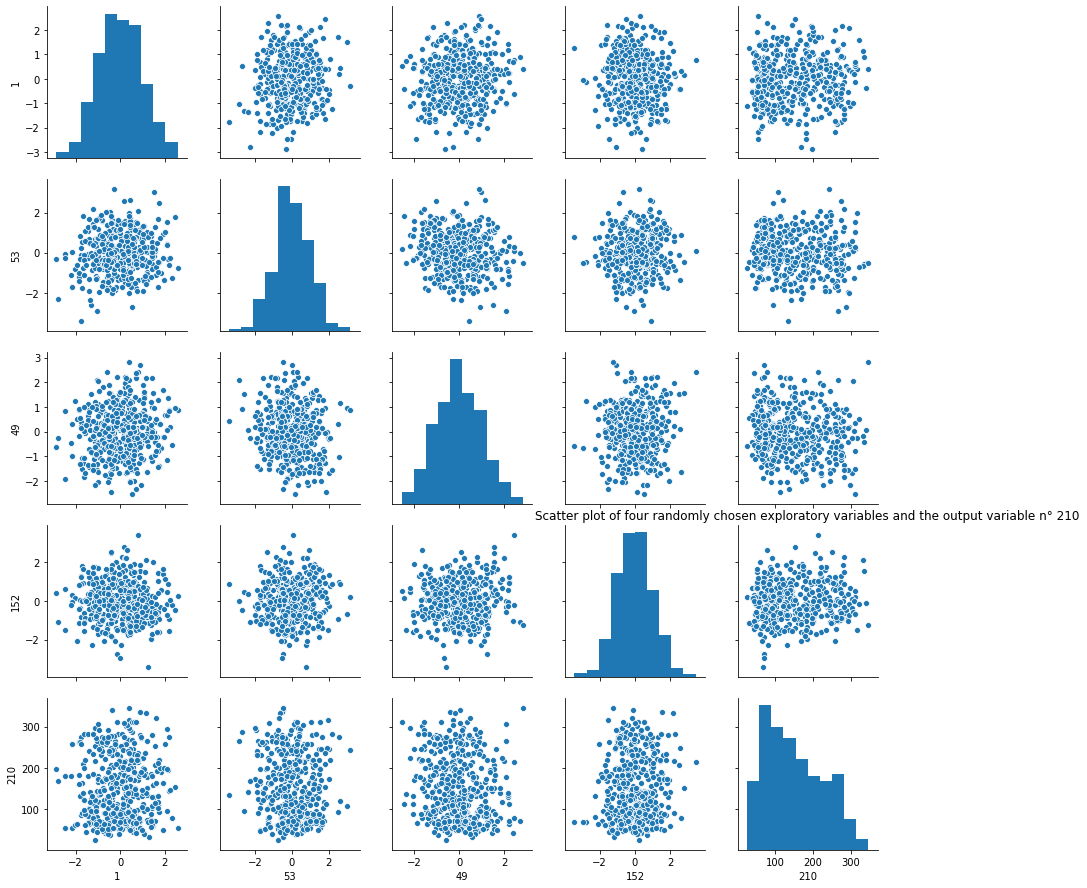

In [4]:
Z=np.append(np.random.randint(0,209,4),210)
seaborn.pairplot(data[Z])
plt.title("Scatter plot of four randomly chosen exploratory variables and the output variable n° 210")
plt.show()

On the scatter of randomly chosen exploratory variables and the output variable, we can observe cloud of points. It seems that there is no correlation between the variables.

3)

In [5]:
index_test = rd.sample(range(n), n//5)
index_train = np.setdiff1d(range(n), index_test)

test = data.values[index_test]
X_test = test[:,:p-1]

train = data.values[index_train]
X_train = train[:,:p-1]

Y_test = test[:,p-1]
Y_train = train[:,p-1]

n_test=len(X_test)
n_train=len(X_train)

print("Size of X_test = ",n_test," observations. ")
print("Size of X_train = ",n_train," observations. ")

Size of X_test =  88  observations. 
Size of X_train =  354  observations. 


4)

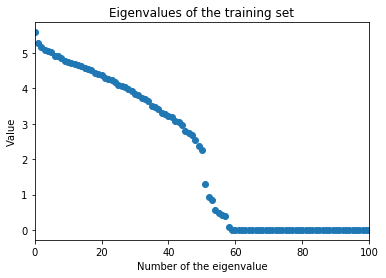

In [6]:
Cov_train = np.cov(X_train.T)
u, eig_train,vh= np.linalg.svd(Cov_train)
plt.figure()
nb_eig=len(eig_train)
plt.plot([i for i in range(nb_eig)],eig_train, 'o')
plt.title("Eigenvalues of the training set")
plt.xlabel("Number of the eigenvalue")
plt.ylabel("Value")
plt.xlim(0, 100)
plt.show()

The 60 first eigenvalues are the only ones which aren't equal to zero, therefore we will keep those 60 variables.

5)

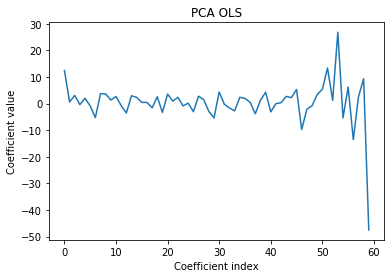

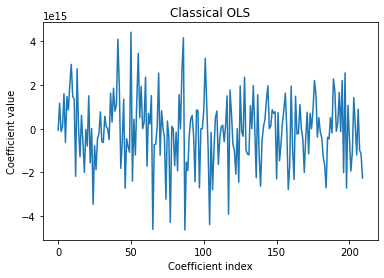

In [7]:
#PCA OLS
pca=np.dot(X_train,u[:,:60])
pca_ols=sklearn.linear_model.LinearRegression().fit(pca,Y_train)

plt.figure()
plt.plot([i for i in range(60)],pca_ols.coef_, '-')
plt.title("PCA OLS")
plt.ylabel("Coefficient value")
plt.xlabel("Coefficient index")
plt.show()

#Classical OLS
classic_ols=sklearn.linear_model.LinearRegression().fit(X_train,Y_train) 

plt.figure()
plt.plot([i for i in range(210)],classic_ols.coef_, '-')
plt.title("Classical OLS")
plt.ylabel("Coefficient value")
plt.xlabel("Coefficient index")
plt.show()


6)

In [8]:
print("Intercept of the PCA OLS : ", np.round(pca_ols.intercept_,2))
print("Intervept of th classical OLS : ", np.round(classic_ols.intercept_,2))
print("Mean value of Y_train: ", np.round(np.mean(Y_train),2))


Intercept of the PCA OLS :  151.02
Intervept of th classical OLS :  151.6
Mean value of Y_train:  151.81


The intercept aren't equal, and they aren't equal to the mean value of Y_train, as it should be if the variables where centralized and normalized.

In [9]:
#Normalize X_train
pca_normalized = pca.copy()
for i in range(60):
    pca_mean=np.mean(pca[:,i])
    pca_var=np.var(pca[:,i])
    for j in range(len(pca)):
        pca_normalized[j,i]=(pca[j,i]-pca_mean)/np.sqrt(pca_var)

#Linear regression
normalized_PCA_OLS = sklearn.linear_model.LinearRegression().fit(pca_normalized,Y_train)

print("\nIntercept of the PCA OLS centered and normalized : ", np.round(normalized_PCA_OLS.intercept_,2))
print("Intervept of the classical OLS : ", np.round(classic_ols.intercept_,2))
print("Mean value of Y_train: ", np.round(np.mean(Y_train),2))


Intercept of the PCA OLS centered and normalized :  151.81
Intervept of the classical OLS :  151.6
Mean value of Y_train:  151.81


Now that the PCA is normalized and centered, its intercept is equal to the main value of Y_train. 

7)

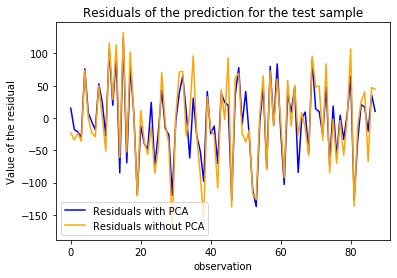

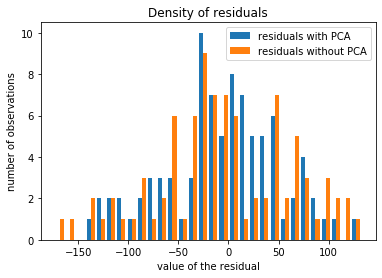

Determination coefficient with PCA :  0.64379
Determination coefficient without PCA :  0.4478
Prediction risk with PCA :  3309.8
Prediction risk without PCA :  4519.1


In [10]:
#Residuals
pca_eps = pca_ols.predict(np.dot(X_test,u[:,:60])) - Y_test
classic_eps = classic_ols.predict(X_test) - Y_test
plt.figure()
plt.plot(pca_eps,'-',color='b')
plt.plot(classic_eps,'-',color='orange')
plt.legend(("Residuals with PCA", "Residuals without PCA"))
plt.title("Residuals of the prediction for the test sample")
plt.xlabel("observation")
plt.ylabel("Value of the residual")
plt.show()

#Histogramm
plt.figure()
plt.hist([pca_eps, classic_eps], 30)
plt.legend(("residuals with PCA", "residuals without PCA"))
plt.title("Density of residuals")
plt.ylabel("number of observations")
plt.xlabel("value of the residual")
plt.show()

#Determination coefficient
print("Determination coefficient with PCA : ", np.round(np.sqrt(pca_ols.score(np.dot(X_test,u[:,:60]),Y_test)),5))
print("Determination coefficient without PCA : ", np.round(np.sqrt(classic_ols.score(X_test,Y_test)),5))

#Prediction risk
R_pred_PCA = (np.linalg.norm(Y_test - pca_ols.predict(np.dot(X_test,u[:,:60])))**2)/ (n//5)
R_pred_classical = (np.linalg.norm(Y_test - classic_ols.predict(X_test))**2)/ (n//5)
print("Prediction risk with PCA : ",np.round(R_pred_PCA,1))
print("Prediction risk without PCA : ",np.round(R_pred_classical,1))

The regression with PCA has better results than the classical OLS. Indeed the determination coefficient with PCA is bigger, and the risk is smaller. 

8)

In [11]:
def p_value(val):
    return 2*(1-norm.cdf(np.abs(val)))

def value_test(col,Y_):
    X_new=np.c_[np.array([1 for i in range(354)]).T,col]
    G=np.linalg.inv(np.dot(np.transpose(X_new),X_new))/(354)
    s=np.sqrt(G[0][0])
    reg=sklearn.linear_model.LinearRegression().fit(col.reshape(-1, 1),Y_)
    sigma=(np.sum((Y_-reg.predict(np.array([col]).T))**2)/352)
    T=reg.coef_[0]/(s*sigma)
    return T

def forward_variable_selection(X_,Y_,A,stop=False):
    p_stop=0.1
    Tn=[]
    P=[]
    
    if len(A)==1:
        return [A[0]]

    for k in range(len(X_[0])):
        col=X_[:,k]
        t=value_test(col,Y_)
        Tn.append(t) 
        P.append(p_value(t))
    
    max_index=np.argmax(Tn)
    minimum=np.min(P)
    if minimum>0.1 and stop==True :
        return []
        
    l=A.pop(max_index)
    
    regression=sklearn.linear_model.LinearRegression().fit(X_[:,max_index].reshape(-1, 1),Y_)
    r_=Y_-regression.intercept_*np.array([1 for i in range(354)])-regression.coef_[0]*X_[:,max_index]
    x_=np.delete(X_, max_index, axis=1)
    
    return [l]+forward_variable_selection(x_,r_,A,stop)



In [12]:
print("Order of the variable selection in ascending order : ")
L=forward_variable_selection(X_train,Y_train,[i for i in range(210)])
print(L)

Order of the variable selection in ascending order : 
[58, 123, 167, 22, 117, 168, 204, 86, 146, 121, 5, 13, 66, 47, 9, 93, 110, 192, 61, 171, 184, 10, 114, 67, 56, 208, 111, 138, 191, 44, 65, 169, 163, 72, 89, 77, 207, 45, 90, 149, 30, 115, 139, 176, 91, 177, 125, 95, 81, 69, 159, 92, 182, 62, 80, 119, 73, 113, 57, 193, 142, 175, 49, 116, 143, 136, 209, 154, 1, 42, 54, 28, 196, 198, 106, 48, 75, 197, 0, 3, 108, 105, 41, 181, 188, 100, 39, 172, 35, 148, 71, 40, 112, 151, 78, 29, 166, 15, 21, 6, 104, 150, 180, 155, 152, 2, 156, 118, 189, 141, 101, 46, 173, 96, 11, 55, 8, 164, 127, 131, 124, 128, 37, 70, 74, 51, 36, 199, 120, 187, 68, 107, 126, 25, 165, 183, 87, 202, 162, 137, 194, 83, 85, 185, 84, 206, 161, 19, 195, 203, 76, 190, 12, 147, 97, 144, 64, 59, 33, 94, 170, 88, 27, 109, 179, 130, 26, 122, 7, 153, 63, 16, 145, 43, 98, 200, 17, 132, 38, 4, 50, 102, 60, 103, 129, 134, 178, 82, 158, 52, 20, 186, 157, 18, 32, 14, 140, 201, 31, 24, 160, 53, 205, 34, 99, 23, 135, 79, 133, 174]


9)

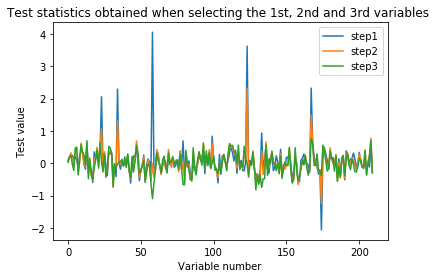

In [13]:
Y_=Y_train.copy()
plt.figure()
for k in range(3) :
    plt.plot(np.arange(p-1),[value_test(X_train[:,j],Y_) for j in range(p-1)],label="step" +str(k+1))
    reg=sklearn.linear_model.LinearRegression().fit(X_train[:,L[k]].reshape(-1, 1),Y_)
    Y_=Y_-reg.predict(np.array([X_train[:,L[k]]]).T)
    
plt.xlabel("Variable number")
plt.ylabel("Test value")
plt.legend(loc=1)
plt.title("Test statistics obtained when selecting the 1st, 2nd and 3rd variables ")
plt.show()


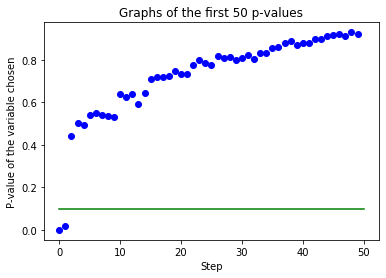

Selected variables : [58, 123]


In [14]:
plt.figure()
Y_=Y_train.copy()
for i in range(50):
    plt.plot(i,p_value(value_test(X_train[:,L[i]],Y_)),'o',color='b')
    reg=sklearn.linear_model.LinearRegression().fit(X_train[:,L[i]].reshape(-1, 1),Y_)
    Y_=Y_-reg.predict(np.array([X_train[:,L[i]]]).T)
    
plt.plot(np.linspace(0,50,50),[0.1]*50,'-',color='g')
plt.xlabel("Step")
plt.ylabel("P-value of the variable chosen")
plt.title("Graphs of the ﬁrst 50 p-values")
plt.show()

selected_variables=forward_variable_selection(X_train,Y_train,[i for i in range(210)],stop=True)

print("Selected variables :" , selected_variables)

10)

Determination coefficient : 0.71218
Prediction risk: 2785.6


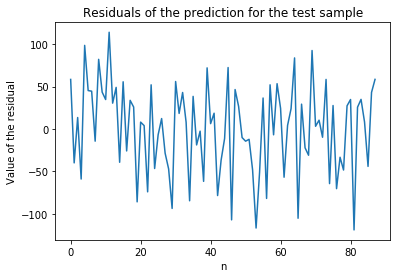

In [15]:
X_train_selected=np.c_[X_train[:,58],X_train[:,123]]
X_test_selected=np.c_[X_test[:,58],X_test[:,123]]

ols_selected = sklearn.linear_model.LinearRegression().fit(X_train_selected, Y_train)

Y_prediction = ols_selected.predict(X_test_selected)
residuals = (Y_prediction - Y_test)

prediction_risk=np.mean(np.linalg.norm(Y_test - Y_prediction)**2) / (n//5)

print("Determination coefficient :", np.round(np.sqrt(ols_selected.score(X_test_selected, Y_test)),5))
print("Prediction risk:",np.round(prediction_risk,1))

plt.plot(range(len(Y_test)), residuals)
plt.title("Residuals of the prediction for the test sample")
plt.xlabel("n")
plt.ylabel("Value of the residual")
plt.show()

This method is better than the classical OLS. In this case, the forward variable selection is also better than the PCA before OLS, but it depends of the test sample. Yet, this method has a longer computationnal time. 

11)

In [16]:
m=len(X_train)
rd.shuffle(index_train)

fold = 4*[[]]
for i in range(4) :
    fold[i]=data.values[index_train[i*m//4:(i+1)*m//4]]
    print("number of observations in fold ",i," : ", len(fold[i]))


number of observations in fold  0  :  88
number of observations in fold  1  :  89
number of observations in fold  2  :  88
number of observations in fold  3  :  89


12)

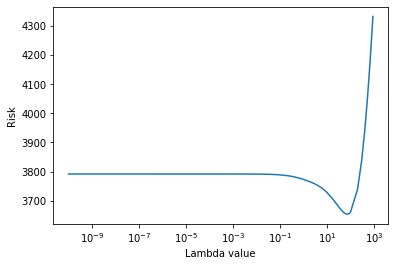

Lambda chosen for the Ridge regression :  70
Best risk of the Ridge regression : 3654.4


In [23]:
lambda_grid= [1e-10]+[i * 10**j for j in range(-3,3) for i in range(1,10)]
risk = np.zeros(len(lambda_grid))

for k in range(len(fold)):
    X_train_fold=np.concatenate([fold[i][:,:p-1] for i in range(len(fold)) if i!=k])
    Y_train_fold=np.concatenate([fold[i][:,p-1] for i in range(len(fold)) if i!=k])
    X_test_fold=fold[k][:,:p-1]
    Y_test_fold=fold[k][:,p-1]
    for i in range(len(lambda_grid)):
        ridge = Ridge(lambda_grid[i]).fit(X_train_fold, Y_train_fold)
        risk[i] += ((np.linalg.norm(ridge.predict(X_test_fold) - Y_test_fold)**2)/len(Y_test_fold))/4

plt.plot(lambda_grid, risk)
plt.xscale("log")
plt.ylabel("Risk")
plt.xlabel("Lambda value")
plt.show()

lamb=np.argmin(risk)
print("Lambda chosen for the Ridge regression : ", lambda_grid[lamb])
print("Best risk of the Ridge regression :", np.round(risk[lamb],1))

We choose lambda which minimizes the risk.

In [24]:
ridge = Ridge(lamb).fit(X_test, Y_test)
risk = ((np.linalg.norm(ridge.predict(X_test) - Y_test)**2)/len(Y_test))
print("Risk of the Ridge regression :", np.round(risk,1))
print("Determination coefficient associated :", np.round(np.sqrt(ridge.score(X_test, Y_test)),5))


Risk of the Ridge regression : 1029.2
Determination coefficient associated : 0.90439


This method has better results than the others.

13)

In [18]:
lasso= LassoCV(cv = 4).fit(X_train, Y_train)
print("Regularization parameter for the LASSO :",np.round(lasso.alpha_,3))
print("Risk of the LASSO prediction :", np.round(np.sum((lasso.predict(X_test) - Y_test)**2)/len(Y_test),1))
print("Determination coefficient associated :", np.round(np.sqrt(lasso.score(X_test, Y_test)),5))

Regularization parameter for the LASSO : 5.478
Risk of the LASSO prediction : 2600.2
Determination coefficient associated : 0.73485


The lasso seems as good as the PCA before OLS or the forward variable selection, but not as the ridge regression.

14)

In [19]:
nb_lasso_var=0
for i in range(len(lasso.coef_)):
    if lasso.coef_[i]!=0:
        if nb_lasso_var==0:
            X_lasso_train=X_train[:,i]
            X_lasso_test=X_test[:,i]
        else:
            X_lasso_train=np.c_[X_train[:,i],X_lasso_train]
            X_lasso_test=np.c_[X_test[:,i],X_lasso_test]
        nb_lasso_var+=1
        
ols_lasso = sklearn.linear_model.LinearRegression().fit(X_lasso_train, Y_train)
print("Number of LASSO variables : ", nb_lasso_var)
print("Prediction risk for least-square LASSO :",np.round(np.sum((ols_lasso.predict(X_lasso_test)-Y_test)**2)/len(Y_test),1))
print("Determination coefficient associated :", np.round(np.sqrt(ols_lasso.score(X_lasso_test, Y_test)),5))



Number of LASSO variables :  15
Prediction risk for least-square LASSO : 2745.1
Determination coefficient associated : 0.7172


Those two lasso methods seems to have has good results.